Le dataset que nous utilisons dans cette analyse concerne un ensemble de données de la NASA obtenu à partir d’une série d’essais aérodynamiques et acoustiques de sections de pales bidimensionnelles et tridimensionnelles menées dans une soufflerie anéchoïque.
<br>
<br>
**Statistiques de base :**
* Nombre de lignes : 1503
* Nombre de colonnes : 6
* Valeurs manquantes : 0
<br>
<br>

**Objectif de l'analyse :**
<br>
Notre objectif principal est de développer un modèle de prédiction pour le niveau de pression acoustique mis à l'échelle en décibels. Pour cela nous allons utiliser une technique de régression.
<br>
<br>

**Sources utilisées :**
<br>

# **Imports <br> Initialisation des variables**

In [1]:
# pip install scikit-learn, xgboost, catboost, lightgbm, matplotlib, numpy, pandas, seaborn, MiniSom
from sklearn.ensemble import (BaggingRegressor,
                              ExtraTreesRegressor,
                              RandomForestRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             mean_absolute_error as MAE,
                             mean_squared_error as MSE,
                             precision_score,
                             recall_score,
                             r2_score)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from skopt import BayesSearchCV

from xgboost import XGBRegressor
# !pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import numpy as np
# print(np.__version__)

import pandas as pd
import seaborn as sns

# !pip install MiniSom
from minisom import MiniSom

data = pd.read_csv(r'C:\Users\godai\Documents\BUT\3e_annee\semestre_5\Données massives\Prediction_pression_accoustique\AirfoilSelfNoise.csv')


# **Renommage des colonnes**

In [2]:
data = data.rename(columns={'f': 'fq_hertz',
                            'alpha': 'angle_attaque',
                            'c': 'longueur_corde',
                            'U_infinity': 'vitesse_flux_libre',
                            'delta': 'epaisseur_dep_aspiration',
                            'SSPL': 'pression_accoustique'})
display(data.head(2))

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201


# **Apperçu du dataset**

In [3]:
# apperçu des données*
print("\tDIMENSIONS DU DATA (lignes, colonnes) :", data.shape)
print("\n\n\tPREMIERES LIGNES")
display(data.head(3))
print("\n\n\tINFORMATIONS SUR LE DATA")
print(data.info(), "\n\n")

	DIMENSIONS DU DATA (lignes, colonnes) : (1503, 6)


	PREMIERES LIGNES


,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951




	INFORMATIONS SUR LE DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fq_hertz                  1503 non-null   int64  
 1   angle_attaque             1503 non-null   float64
 2   longueur_corde            1503 non-null   float64
 3   vitesse_flux_libre        1503 non-null   float64
 4   epaisseur_dep_aspiration  1503 non-null   float64
 5   pression_accoustique      1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None 




# **Nettoyage et statistiques récapitulatives du dataset**

In [4]:
# affichage des données nulles
display(data.isnull().sum())

data = data.dropna() # supprimer les lignes qui contiennent des valeurs manquantes
data = data.drop_duplicates() # supprimer les doublons

fq_hertz                    0
angle_attaque               0
longueur_corde              0
vitesse_flux_libre          0
epaisseur_dep_aspiration    0
pression_accoustique        0
dtype: int64

## Remarque
Pas de valeurs manquantes

In [5]:
display(data.describe())

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Remarques
On remarque des valeurs aberrantes dans la première et la deuxième colonnes car le maximum est très éloigné du 3e quartile.

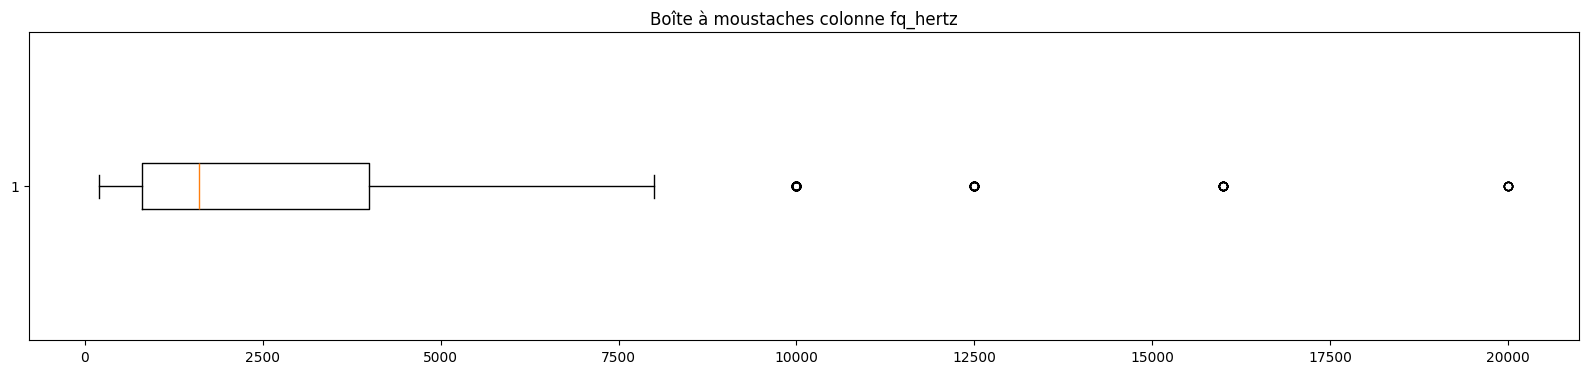

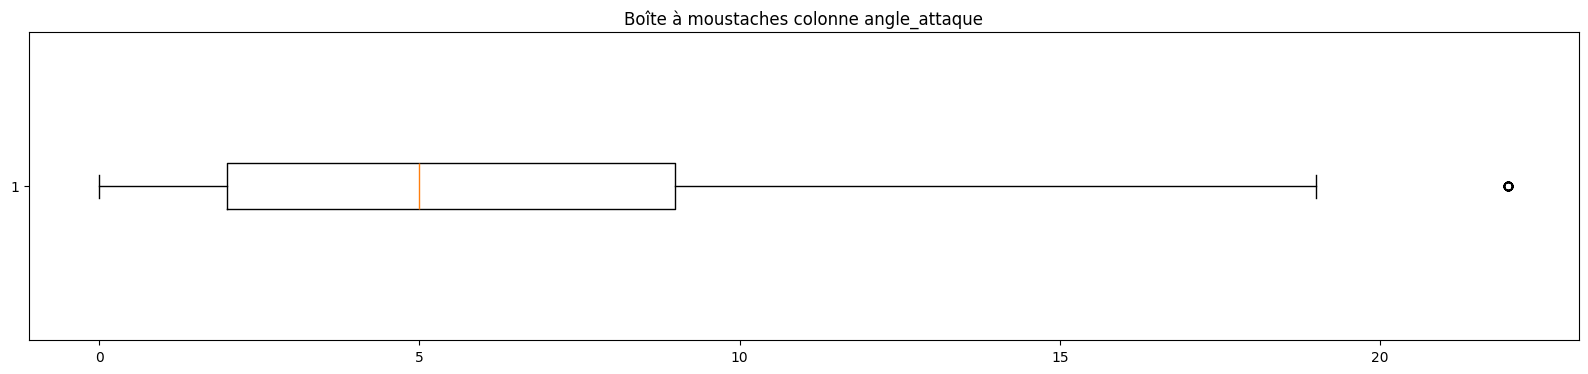

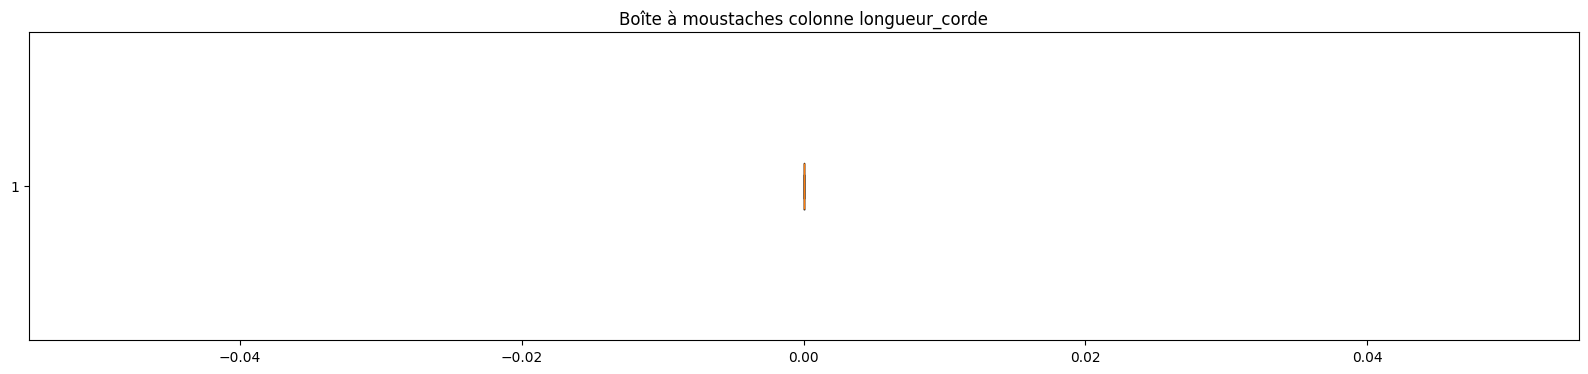

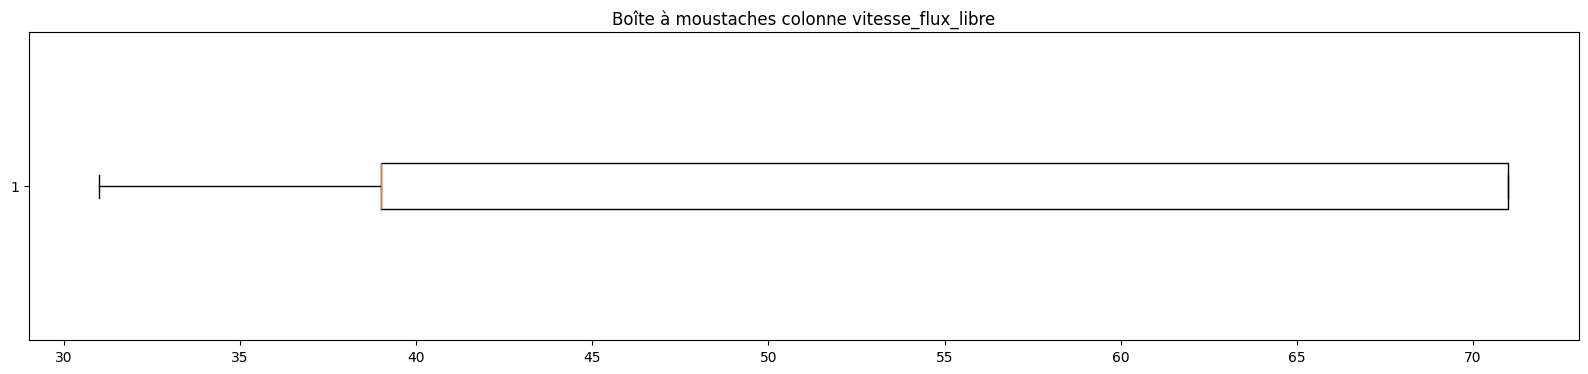

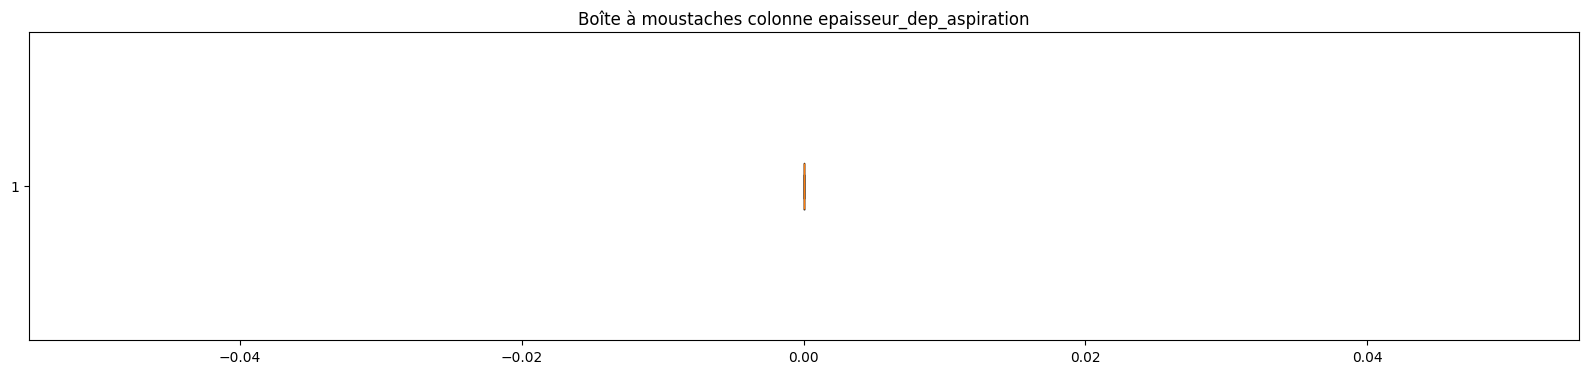

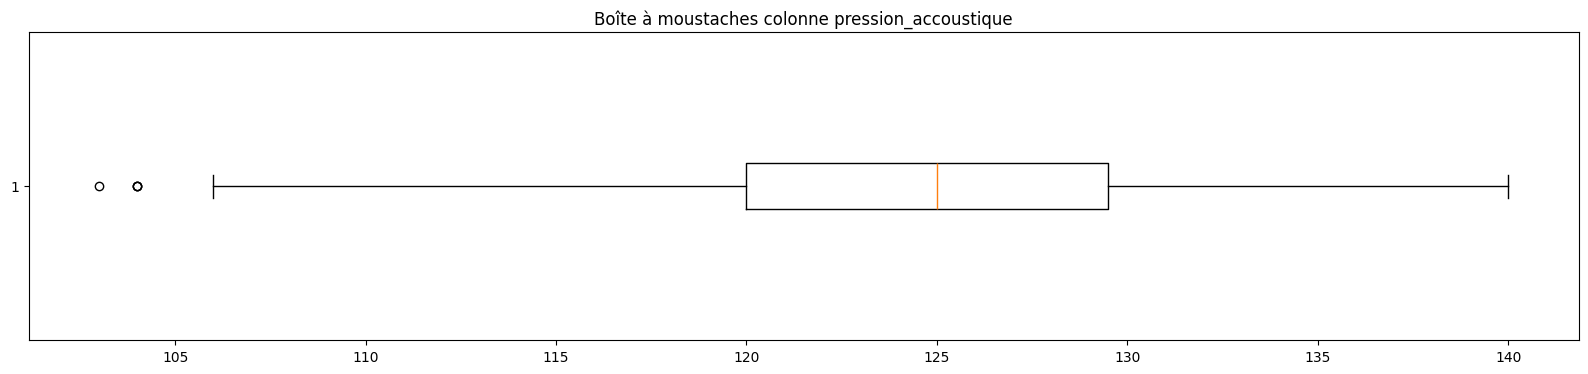

In [6]:
def remplacer_valeurs_aberrantes(data, column):
  valeurs = data[column].astype(float)

  # Calcul des quartiles
  q1 = valeurs.quantile(0.25)
  q3 = valeurs.quantile(0.75)

  # Calcul de la plage interquartiles
  iqr = q3 - q1

  # Calcul des limites des moustaches
  moustache_inferieure = q1 - 1.5 * iqr
  moustache_superieure = q3 + 1.5 * iqr

  # Remplacement des valeurs aberrantes par des valeurs entre le premier et le troisième quartile
  data.loc[data[column] < moustache_inferieure, column] = moustache_inferieure
  data.loc[data[column] > moustache_superieure, column] = moustache_superieure


def affichage_box_plot(column):
  valeurs = data[column].astype(int).tolist()
  plt.figure(figsize=(20, 4))
  plt.boxplot(valeurs, vert=False)
  plt.title(f'Boîte à moustaches colonne {column}')
  plt.show()

for column in data.columns:
    # remplacer_valeurs_aberrantes(data, column)
    affichage_box_plot(column)

# **=========================================================================================Exploratory_Data_Analysis_(EDA)=========================================================================================**

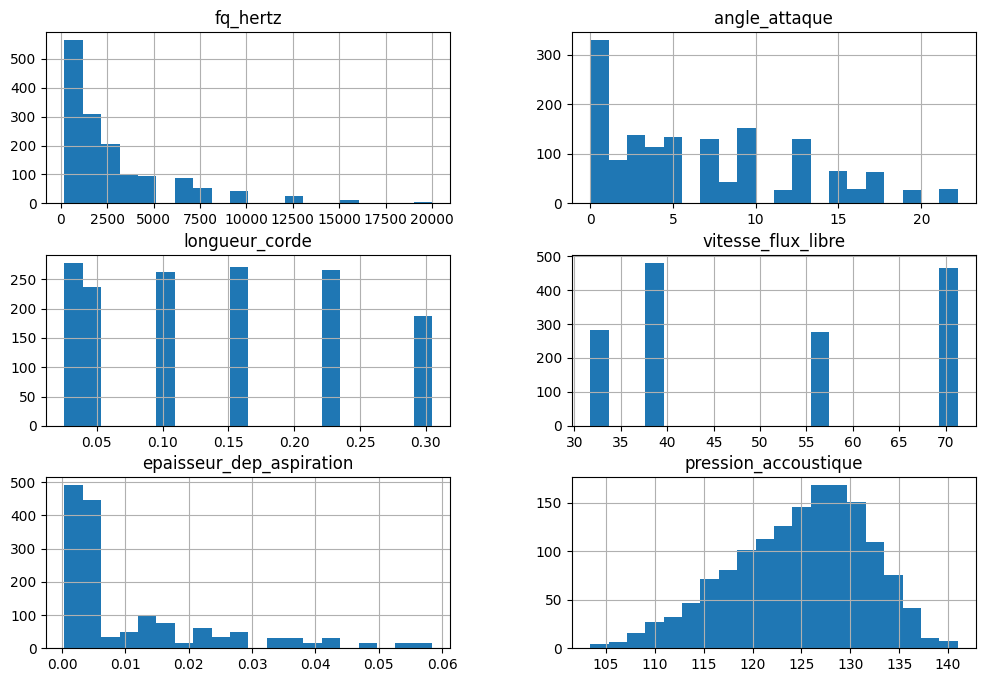

In [8]:
data.hist(bins=20, figsize=(12, 8))
plt.show()

# **Matrice de corrélation**

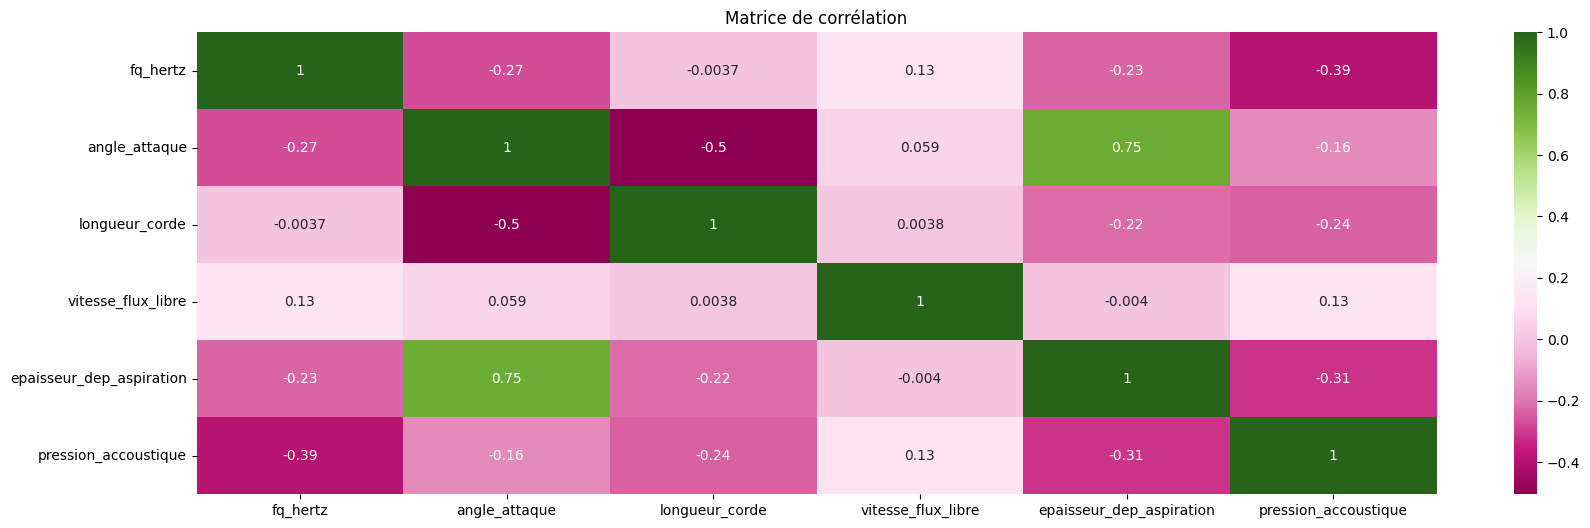

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
fq_hertz,1.0,-0.272765,-0.003661,0.133664,-0.230107,-0.390711


In [7]:
# variables
matrice = data.corr()

# graph
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

## Remarques
* -1 < valeurs matrice < 1
    - valeur proche de 1 --> corrélation forte
    - valeur proche de 0 --> corrélation faible
    - valeur proche de -1 --> corrélation négative
* valeurs > 0 --> corrélation positive : les deux variables augmentent ou diminuent ensemble
* valeurs < 0 --> corrélation négative : les deux variables augmentent ou diminuent dans des directions opposées
<br>
<br>

On remarque principalement que :
* il y a une corrélation positive entre l'angle d'attaque et l'épaisseur du déplacement coté aspiration
* il y a une corrélation négative entre l'angle d'attaque et la longueur de la corde
* il y a une corrélation négative entre la pression accoustique et la fréquence

# **=====================================================================================================IA=====================================================================================================**

# **Preprossessing of data**

In [9]:
target = data['pression_accoustique']
preprocessed_data = data.drop(columns=[f'{target.name}']) # on enlève la variable cible

scaler = StandardScaler()

n_components = 2

# **PCA (Analyse en Composition Principales)**

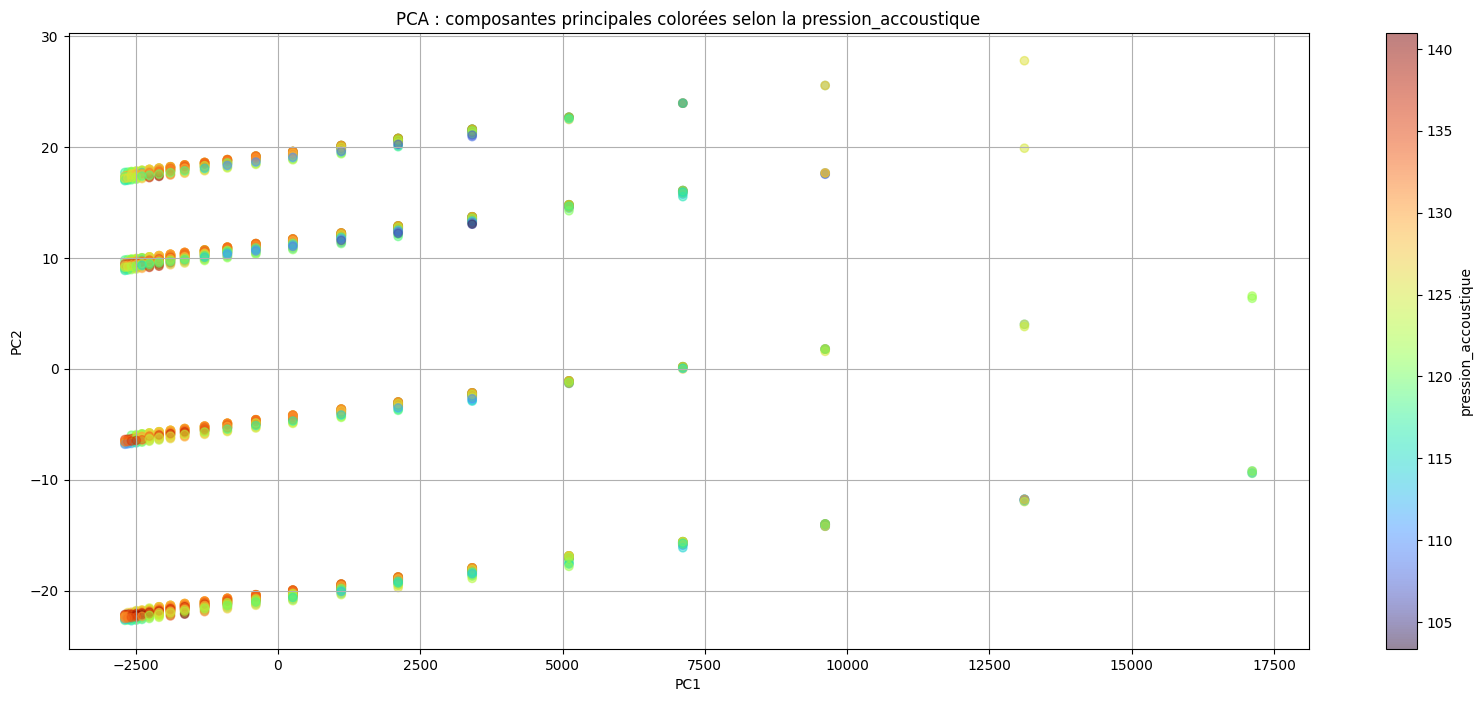

In [10]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(preprocessed_data)
principal_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
plt.figure(figsize=(20, 8))
plt.scatter(principal_df["PC1"], principal_df["PC2"], c=target, cmap='turbo', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA : composantes principales colorées selon la {target.name}")
plt.colorbar(label=f'{target.name}')
plt.grid()
plt.show()

In [11]:
# Obtenir les valeurs propres
eigenvalues = pca.explained_variance_ratio_

print("{:<15} {:<2.6f} {:<15} {:<2.6f}".format("Valeurs propres PC1 :", eigenvalues[0], "Valeurs propres PC2 :", eigenvalues[1]))

Valeurs propres PC1 : 0.999973 Valeurs propres PC2 : 0.000024


## Remarques
PC1 et PC2 sont des combinaisons linéaires de des variables d'origine qui permettent de représenter les données d'une manière qui maximise la variance
<br>
--> But : réduire la dimensionnalité des données tout en préservant un maximum d'informations
<br>
<br>
**Observations :** Les données semblent être linéaires avec une variance élevée. PC1 est la composante qui explique le plus de variance : sa valeur propre (mesure de la variance de la composante) est de 99,9973% contre 0,0024% pour PC2.

# **TSNE (t-distributed stochastic neighbor embedding)**

C:\Users\godai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\godai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


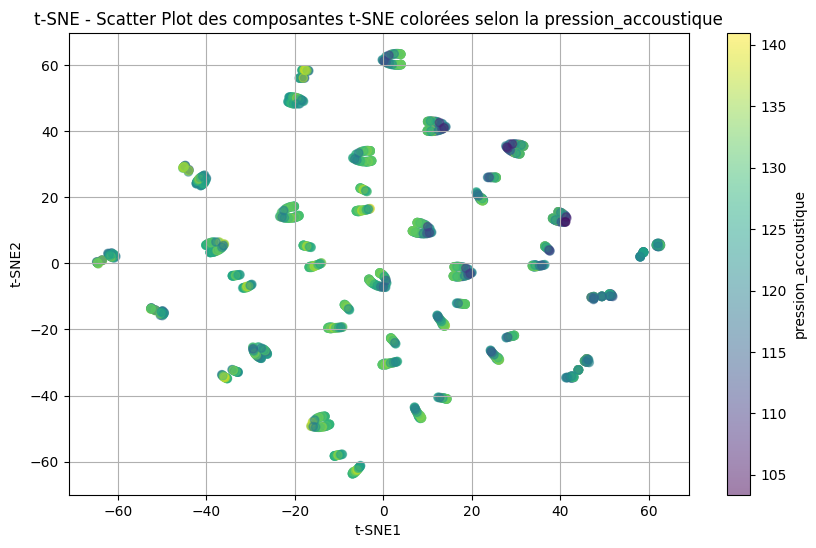

In [12]:
tsne = TSNE(n_components=n_components, perplexity=25, random_state=42)
tsne_components = tsne.fit_transform(preprocessed_data)

tsne_df = pd.DataFrame(data=tsne_components, columns=["t-SNE1", "t-SNE2"])

# graph
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["t-SNE1"], tsne_df["t-SNE2"], c=target, alpha=0.5)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title(f"t-SNE - Scatter Plot des composantes t-SNE colorées selon la {target.name}")
plt.colorbar(label=f'{target.name}')
plt.grid()
plt.show()

## Remarques
* Les données regroupées indiquent des regroupements dans les données
* Les points éloignés peuvent être considérés comme des valeurs aberrantes

# **Self-Organizing Maps (SOM) ~~ cartes auto-organisatrices**

1. **Définition**
* Algorithme d’apprentissage non supervisé (pas de variable cible)
* Algorithme de classification (clustering) qui généralise l’algorithme d’apprentissage compétitif en rajoutant une structure de voisinage entre les classes
* Complexité : linéaire par rapport au nombre de données --> facile à programmer
* Réduire la dimensionnalité des données tout en conservant les structures et les relations entre les données --> facilite l'exploration des données
<br>
<br>
2. **Fonctionnement**
* Les cartes auto-organisatrices de **Kohonen** (1984) sont constituées d'une grille. Dans chaque nœud de la grille se trouve un « neurone »
* Chaque neurone est associé à un vecteur de poids initialisé aléatoirement.
* Chaque neurone calcule sa similarité avec les données d'entrée (mesures telles que la distance euclidienne)
* **Neurone gagnant** = neurone dont le vecteur de poids est le plus similaire aux données
* Les vecteurs de poids des neurones voisins du neurone gagnant sont ajustés pour devenir plus similaires aux données d'entrée --> forme des groupes / clusters
<br>
<br>
Les paramètres de SOM sont les suivants :
* x : som_grid_rows, est le nombre de lignes
* y : som_grid_columns, est le nombre de colonnes
* Sigma est le rayon du voisinage
* learning_rate
<br>
<br>
Utilisées pour visualiser des données telles que des images, des séquences temporelles ou des caractéristiques complexes.

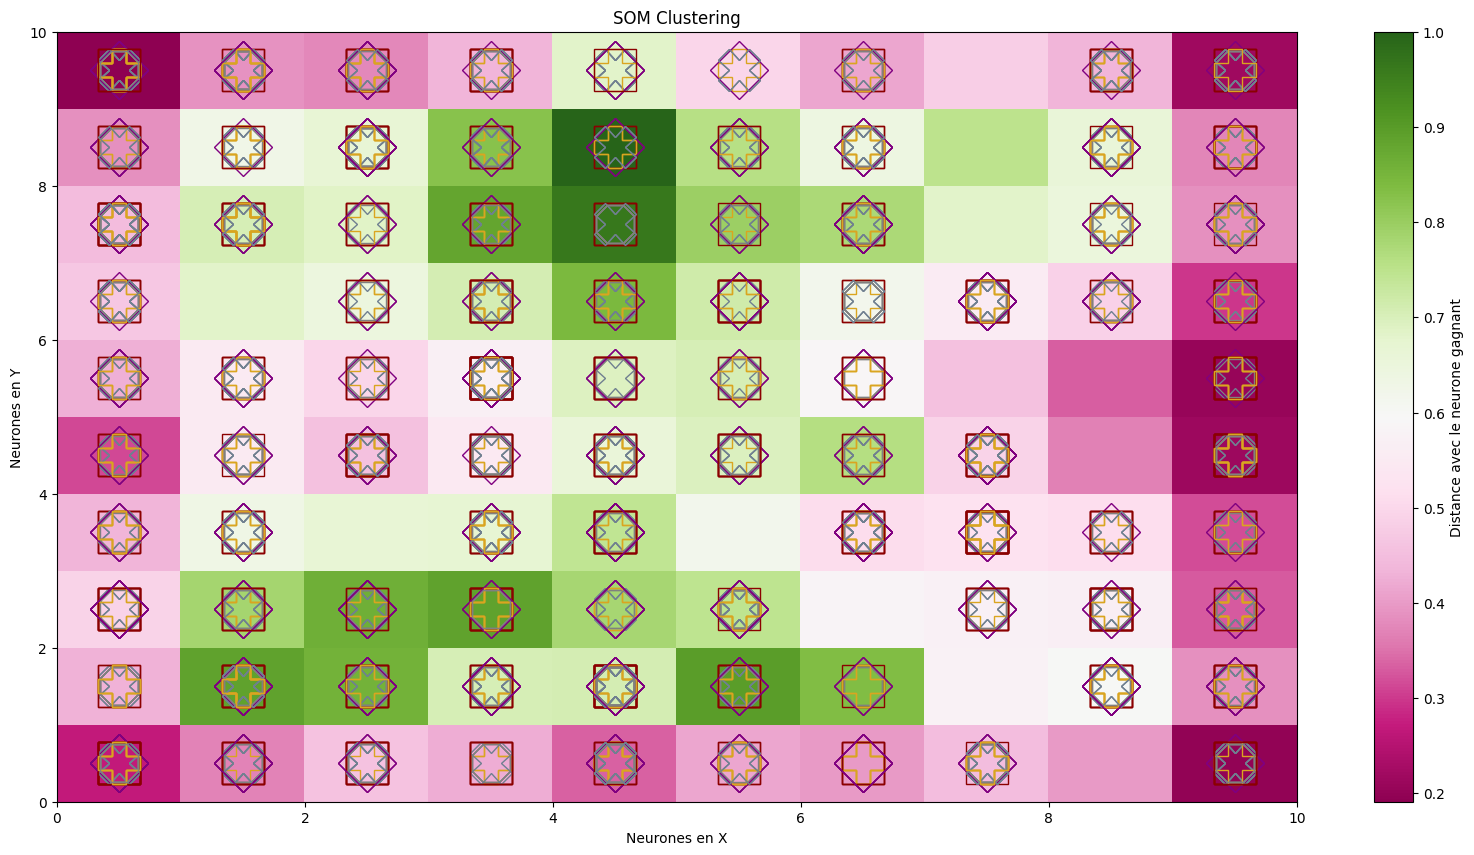

In [13]:
# Mise à l’échelle des x variables
min_max_scaler = MinMaxScaler()
x = min_max_scaler.fit_transform(preprocessed_data)
pd.DataFrame(x)

# Set the hyper parameters
som_dimens = (10, 10)
iterations = 20000
sigma = 1
learning_rate = 0.5

# definition de SOM
som = MiniSom(x = som_dimens[0],
              y = som_dimens[1],
              input_len = 5,
              sigma = sigma,
              learning_rate = learning_rate)

# initialisation des poids de façon aléatoire à partir des données d'entrée
som.random_weights_init(x)

# entrainnement de SOM
som.train_random(x, iterations)

# ==============================================================================

# graph avec marqueurs
plt.figure(figsize=(20, 10))
plt.pcolor(som.distance_map().T, cmap='PiYG')
plt.colorbar(label="Distance avec le neurone gagnant")

colors = ['darkred', 'gray', 'purple', 'goldenrod', 'slategrey']
markers = ['s', '8', 'D', 'P', 'X']

for i, x in enumerate(x):
  index = int(target[i] % len(markers))
  winner = som.winner(x)
  plt.plot(winner[0] + 0.5,
           winner[1] + 0.5,
           markers[index],
           markeredgecolor = colors[index],
           markerfacecolor = 'None',
           markersize = 30)

plt.title('SOM Clustering')
plt.xlabel('Neurones en X')
plt.ylabel('Neurones en Y')
plt.show()

## Remarques
Les neurones représentent des clusters de données similaires :
<br>
* La majorité des noeuds ont des valeurs proches du neurone gagnant (couleur rose) --> les données sont rapprochées et se regroupent naturellement.
* Le noeud gagant est celui dont la valeur est minimale (couleur rose foncé) --> son vecteur de poids est le plus similaires aux données d'entrée.
<br>
Il représente le regroupement auquel les données d'entrée spécifiques sont les plus similaires.
<br>
<br>
* Les marqueurs sont utilisés pour indiquer à quelle catégorie chaque neurone est asocié après l'apprentissage de la carte.

# **=======================================================================================Supervised_Machine_Learning_Tasks=======================================================================================**

# **Mise à l'échelle des données**

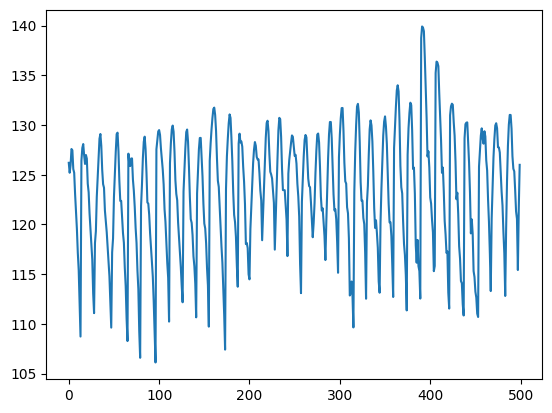

In [21]:
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, np.log(target), test_size = 0.2, random_state = SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(target[:500])

# **Modèles individuels**

Tous sont des algorithmes d'apprentissage supervisé ou modèles individuels.
<br>
<br>

## **Random Forest**
Repose sur des arbres (arbres de décision)

**Fonctionnement :**
* Découpage du dataset en plusieurs sous-ensemble
* Entrainement d'un modèle sur chaque souis-ensemble
* Regroupement de tous les résultats du modèle
<br>
<br>

## **Extra Trees (Extra Trees Regressor)**
Similaire aux arbres de décision, mais avec une touche d'aléatoire

**Fonctionnement :**
* Découpe le dataset en plusieurs sous-ensembles
* Pour chaque sous-ensemble, il crée un arbre de décision avec des règles aléatoires pour réduire le surajustement
* Les résultats de tous les arbres sont combinés pour produire la prédiction finale
<br>
<br>

## **Decision Tree (Decision Tree Regressor)**
Crée un arbre de décision pour la prise de décision

**Fonctionnement :**
* Divise le dataset en fonction des caractéristiques, en essayant de minimiser l'impureté des nœuds
* L'arbre est utilisé pour prendre des décisions en suivant les chemins du haut vers le bas
* Peut être sensible au surajustement (overfitting) s'il est trop profond
<br>
<br>

## **XGBoost (XGBoost Regressor)**

* Algorithme spécialement conçu pour la régression et la classification
* Utilise un ensemble de modèles d'arbres de décision faibles (weak learners)

**Fonctionnement :**
* Les modèles sont formés de manière séquentielle, en corrigeant les erreurs des modèles précédents
* Utilise des techniques de régularisation pour éviter le surajustement
* Donne des performances élevées dans de nombreuses tâches d'apprentissage automatique
<br>
<br>

## **CatBoost (CatBoost Regressor)**
* Algorithme adapté aux données catégorielles
* Gère automatiquement les données catégorielles sans conversion en données numériques
* Utilise un grand nombre d'arbres de décision pour la prédiction
* Utilise un algorithme de gradient pour minimiser la perte
* Est conçu pour être efficace et précis, avec des paramètres par défaut bien ajustés
<br>
<br>

## **LightGBM (LightGBM Regressor)**

* Algorithme conçu pour être rapide et précis
* Utilise un algorithme de gradient pour l'entraînement des arbres
* Utilise une stratégie de division en feuille (Leaf-Wise) pour accélérer la convergence
* Peut gérer des datasets volumineux et dispose d'options de parallélisme
* Dispose de paramètres ajustables pour optimiser les performances en fonction des besoins

In [14]:
results_models = []

In [17]:
def calculateModelsWithDifferentsMetrics(models, X_train, X_test, y_train, y_test):
  measures = [MAE, MSE, r2_score, 'RMSE']

  results = []

  for model_name, model in models:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      model_results = [model_name]

      for measure in measures:
        if measure == 'RMSE':
          result = np.sqrt(MSE(y_test, y_pred))
          model_results.append(result)
        else :
          result = measure(y_test, y_pred)
          model_results.append(result)

      results.append(model_results)
  return results

In [18]:
def graphPerformanceModels(results):
    model_names = [row[0] for row in results]
    mae_values = [row[1] for row in results]
    mse_values = [row[2] for row in results]
    r2_values = [row[3] for row in results]
    rmse_values = [row[4] for row in results]

    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(12, 4))
    plt.bar(index, mae_values, bar_width, label='MAE')
    plt.bar(index + bar_width, mse_values, bar_width, label='MSE')
    plt.bar(index + 2 * bar_width, r2_values, bar_width, label='R2')
    plt.bar(index + 3 * bar_width, rmse_values, bar_width, label='RMSE')

    # plt.plot(index, mae_values, label='MAE')
    # plt.plot(index + bar_width, mse_values, label='MSE')
    # plt.plot(index + 2 * bar_width, r2_values, label='R2')
    # plt.plot(index + 3 * bar_width, rmse_values, label='RMSE')

    plt.xlabel('Modèle')
    plt.ylabel('Valeurs')
    plt.title('Performances des modèles')
    plt.legend()
    plt.xticks(index + 1.5 * bar_width, model_names, rotation=45)

    plt.show()

In [19]:
def affichePerformanceModels(results):
    print("{:<15} \t {:<10} \t {:<10} \t {:<10} \t {:<10}".format("Techniques", "MAE", "MSE", "R2", "RMSE"))
    print("___________________________________________________________________________________")
    for row in results:
        print("{:<15} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f}".format(*row))
        print("___________________________________________________________________________________")

In [22]:
models = [
  ("Random Forest", RandomForestRegressor(random_state = SEED)),
  ("Extra Trees", ExtraTreesRegressor(random_state = SEED)),
  ("Decision Tree", DecisionTreeRegressor(random_state = SEED)),
  ("XGBoost", XGBRegressor(random_state = SEED)),
  ("CatBoost", CatBoostRegressor(random_seed = SEED)),
  ("LightGBM", LGBMRegressor(random_state = SEED))
]
results_models = calculateModelsWithDifferentsMetrics(models, X_train, X_test, y_train, y_test)

C:\Users\godai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Learning rate set to 0.042151
0:	learn: 0.0556330	total: 88.3ms	remaining: 1m 28s
1:	learn: 0.0546125	total: 89.1ms	remaining: 44.4s
2:	learn: 0.0534030	total: 89.8ms	remaining: 29.8s
3:	learn: 0.0523126	total: 90.3ms	remaining: 22.5s
4:	learn: 0.0514012	total: 90.9ms	remaining: 18.1s
5:	learn: 0.0503659	total: 91.5ms	remaining: 15.2s
6:	learn: 0.0493840	total: 92.1ms	remaining: 13.1s
7:	learn: 0.0485998	total: 92.7ms	remaining: 11.5s
8:	learn: 0.0476208	total: 93.4ms	remaining: 10.3s
9:	learn: 0.0468732	total: 94.1ms	remaining: 9.32s
10:	learn: 0.0460047	total: 94.7ms	remaining: 8.52s
11:	learn: 0.0451192	total: 95.3ms	remaining: 7.85s
12:	learn: 0.0443823	total: 95.8ms	remaining: 7.28s
13:	learn: 0.0437691	total: 96.4ms	remaining: 6.79s
14:	learn: 0.0430032	total: 97ms	remaining: 6.37s
15:	learn: 0.0422670	total: 97.5ms	remaining: 6s
16:	learn: 0.0416376	total: 98.1ms	remaining: 5.67s
17:	learn: 0.0409768	total: 98.6ms	remaining: 5.38s
18:	learn: 0.0401680	total: 99.3ms	remaining: 5.

Techniques      	 MAE        	 MSE        	 R2         	 RMSE      
___________________________________________________________________________________
Random Forest   	 0.010      	 0.000      	 0.939      	 0.013     
___________________________________________________________________________________
Extra Trees     	 0.008      	 0.000      	 0.959      	 0.011     
___________________________________________________________________________________
Decision Tree   	 0.014      	 0.000      	 0.882      	 0.018     
___________________________________________________________________________________
XGBoost         	 0.008      	 0.000      	 0.956      	 0.011     
___________________________________________________________________________________
CatBoost        	 0.008      	 0.000      	 0.955      	 0.011     
___________________________________________________________________________________
LightGBM        	 0.010      	 0.000      	 0.931      	 0.014     
____________________

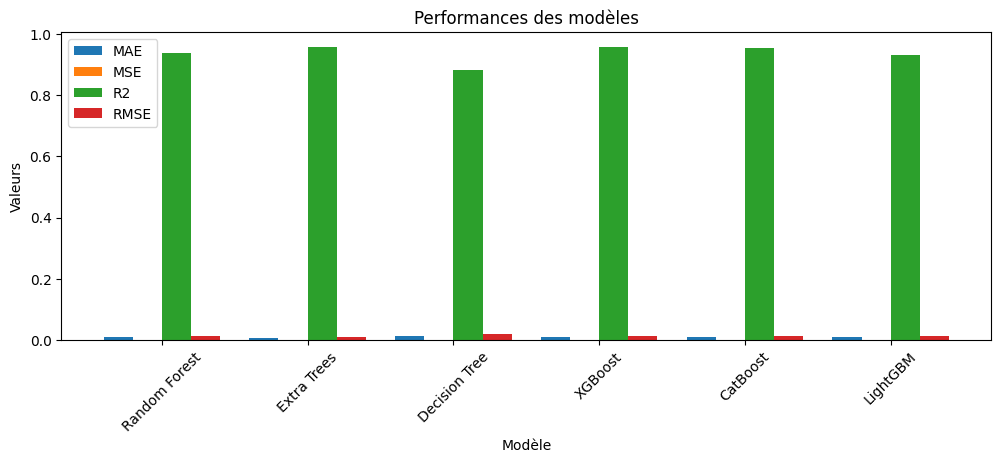

In [23]:
affichePerformanceModels(results_models)
graphPerformanceModels(results_models)

* **MSE** (Mean Squared Error) - Erreur quadratique moyenne. Doit être proche de 0 : prédictions du modèle sont très proches des valeurs réelles
<br>
<br>
* **MAE** (Mean Absolute Error) - Erreur absolue moyenne. Doit être proche de 0 : les écart entre les prédictions et les valeurs réelles sont très faibles
<br>
<br>
* **RMSE** (Root Mean Squared Error) - Erreur quadratique moyenne de la racine carrée. Doit être proche de 0 : même principe, une valeur proche de 0 indique un taux d'erreur dans les prédictions très faible
<br>
<br>
* **R-squared** (R²) - Coefficient de détermination : proportion de la variance dans la variable cible. Doit être proche de 1 : le modèle explique parfaitement la variance des données

## Remarques
Le meilleur modèle est Extra Trees : les valeurs pour MAE, MSE, RMSE sont proche de 0 tandis que la valeur pour R2 est la plus proche de 1.
<br>
Cela signifie que le modèle explique parfaitement la variance des données tandis que le taux d'erreur commise est très faible.

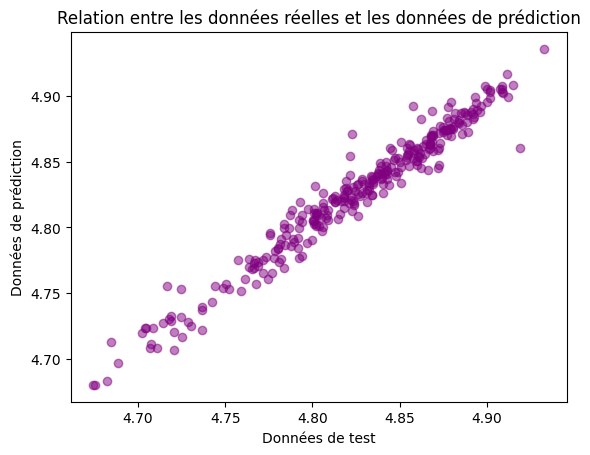

In [24]:
extra_trees_model = ExtraTreesRegressor(random_state = SEED)
extra_trees_model.fit(X_train, y_train)
# y_train = extra_trees_model.predict(X_test)

plt.scatter(y_test, extra_trees_model.predict(X_test), color='purple', alpha = 0.5)
plt.xlabel(xlabel='Données de test')
plt.ylabel(ylabel='Données de prédiction')
plt.title(label='Relation entre les données réelles et les données de prédiction')
plt.show()

## Remarques
* Les données de prédictions et les données originelles forment une ligne avec quelque points en dehors
* On en déduit que les valeurs de prédiction sont presques similaires à celles d'origines